In [18]:
import pymc as pm
from pymc import do
import arviz as az
import numpy as np
from scipy.stats import gaussian_kde

---
# Decathlon draft solution

## Import dependencies

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

## Generate mock data for the test

In [247]:
np.random.seed(42)
N = 10
df_test = pd.DataFrame({
    "researc_dev": np.random.lognormal(mean=3, sigma=2, size=N),
    "ad_spend": np.random.lognormal(mean=4, sigma=1, size=N),
    "tech_perception": np.random.beta(a=2, b=3, size=N),
    "eco_perception": np.random.beta(a=3, b=2, size=N),
    "ventes": np.random.lognormal(mean=np.log(np.random.lognormal(mean=6, sigma=2, size=N)) + np.log(np.random.lognormal(mean=2, sigma=1, size=N)), sigma=0.5, size=N)
})

In [248]:
df_test

,researc_dev,ad_spend,tech_perception,eco_perception,ventes
0,54.240524,34.349323,0.653481,0.397469,64216.628245
1,15.233111,34.269997,0.270598,0.597858,8150.596534
2,73.359871,69.544183,0.311869,0.538900,1181.296974
3,422.445191,8.058438,0.561979,0.576539,6340.575239
4,12.574780,9.728718,0.724644,0.507414,336.769510
5,12.575193,31.115699,0.136094,0.773868,13405.062600
6,472.683311,19.829463,0.487603,0.361244,535.550077
7,93.211347,74.757335,0.408384,0.682196,2378.010503
8,7.854222,22.020546,0.192158,0.516937,1051.862309
9,59.449076,13.299099,0.504169,0.585443,278.048242


In [273]:
df_test.researc_dev.mean()

122.36266267036517

In [274]:
df_test.ad_spend.mean()

31.697280085409595

## Declare the model

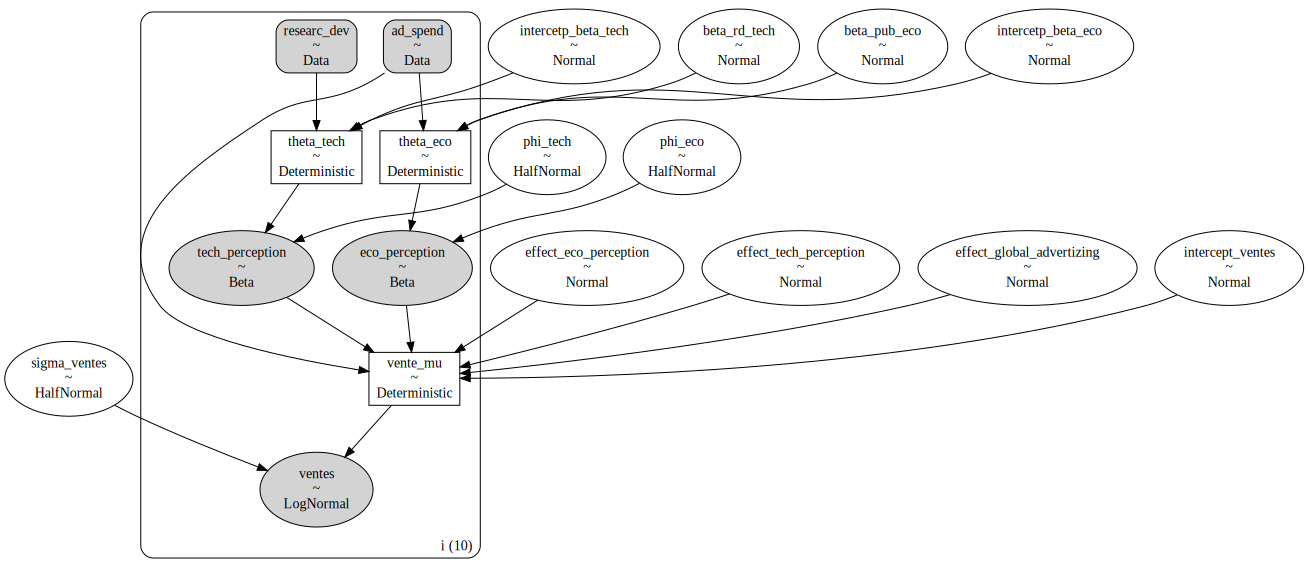

In [249]:
# Modèle de réseau bayésien
with pm.Model(coords={"i": np.arange(N)}) as model:
    # Define priors for parent nodes
    researc_dev = pm.Data('researc_dev', df_test["researc_dev"].values, dims="i")
    ad_spend = pm.Data('ad_spend', df_test["ad_spend"].values, dims="i")

    # Define the model parameters prior for the beta reg of R&D on tech.
    intercetp_beta_tech = pm.Normal('intercetp_beta_tech')
    beta_rd_tech = pm.Normal('beta_rd_tech')
    phi_tech = pm.HalfNormal('phi_tech')
    mu_tech = intercetp_beta_tech + beta_rd_tech * researc_dev
    theta_tech = pm.Deterministic('theta_tech', pm.math.invlogit(mu_tech), dims="i")

    # Define the model parameters prior for the beta reg of pub on eco.
    intercetp_beta_eco = pm.Normal('intercetp_beta_eco')
    beta_pub_eco = pm.Normal('beta_pub_eco')
    phi_eco = pm.HalfNormal('phi_eco')
    mu_eco = intercetp_beta_eco + beta_pub_eco * ad_spend
    theta_eco = pm.Deterministic('theta_eco', pm.math.invlogit(mu_eco), dims="i")

    # Beta likelihood for observed data y
    tech_perception = pm.Beta('tech_perception', alpha=theta_tech * phi_tech, beta=(1 - theta_tech) * phi_tech, dims="i", observed=df_test["tech_perception"].values)
    eco_perception = pm.Beta('eco_perception', alpha=theta_eco * phi_eco, beta=(1 - theta_eco) * phi_eco, dims="i", observed=df_test["eco_perception"].values)

    # Final sur les ventes
    intercept_ventes = pm.Normal('intercept_ventes')
    effect_tech_perception = pm.Normal('effect_tech_perception')
    effect_eco_perception = pm.Normal('effect_eco_perception')
    effect_global_advertizing = pm.Normal('effect_global_advertizing')
    sigma_ventes = pm.HalfNormal("sigma_ventes")
    vente_mu = pm.Deterministic("vente_mu", intercept_ventes + (effect_tech_perception * tech_perception) +
                                (effect_eco_perception * eco_perception) +
                                (effect_global_advertizing * ad_spend), dims="i")
    ventes = pm.LogNormal("ventes", mu=vente_mu, sigma=sigma_ventes, dims="i", observed=df_test["ventes"].values)

pm.model_to_graphviz(model)

## Fit the model

In [250]:
with model:
    idata = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercetp_beta_tech, beta_rd_tech, phi_tech, intercetp_beta_eco, beta_pub_eco, phi_eco, intercept_ventes, effect_tech_perception, effect_eco_perception, effect_global_advertizing, sigma_ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 397 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


## Check the trace to assess convergence

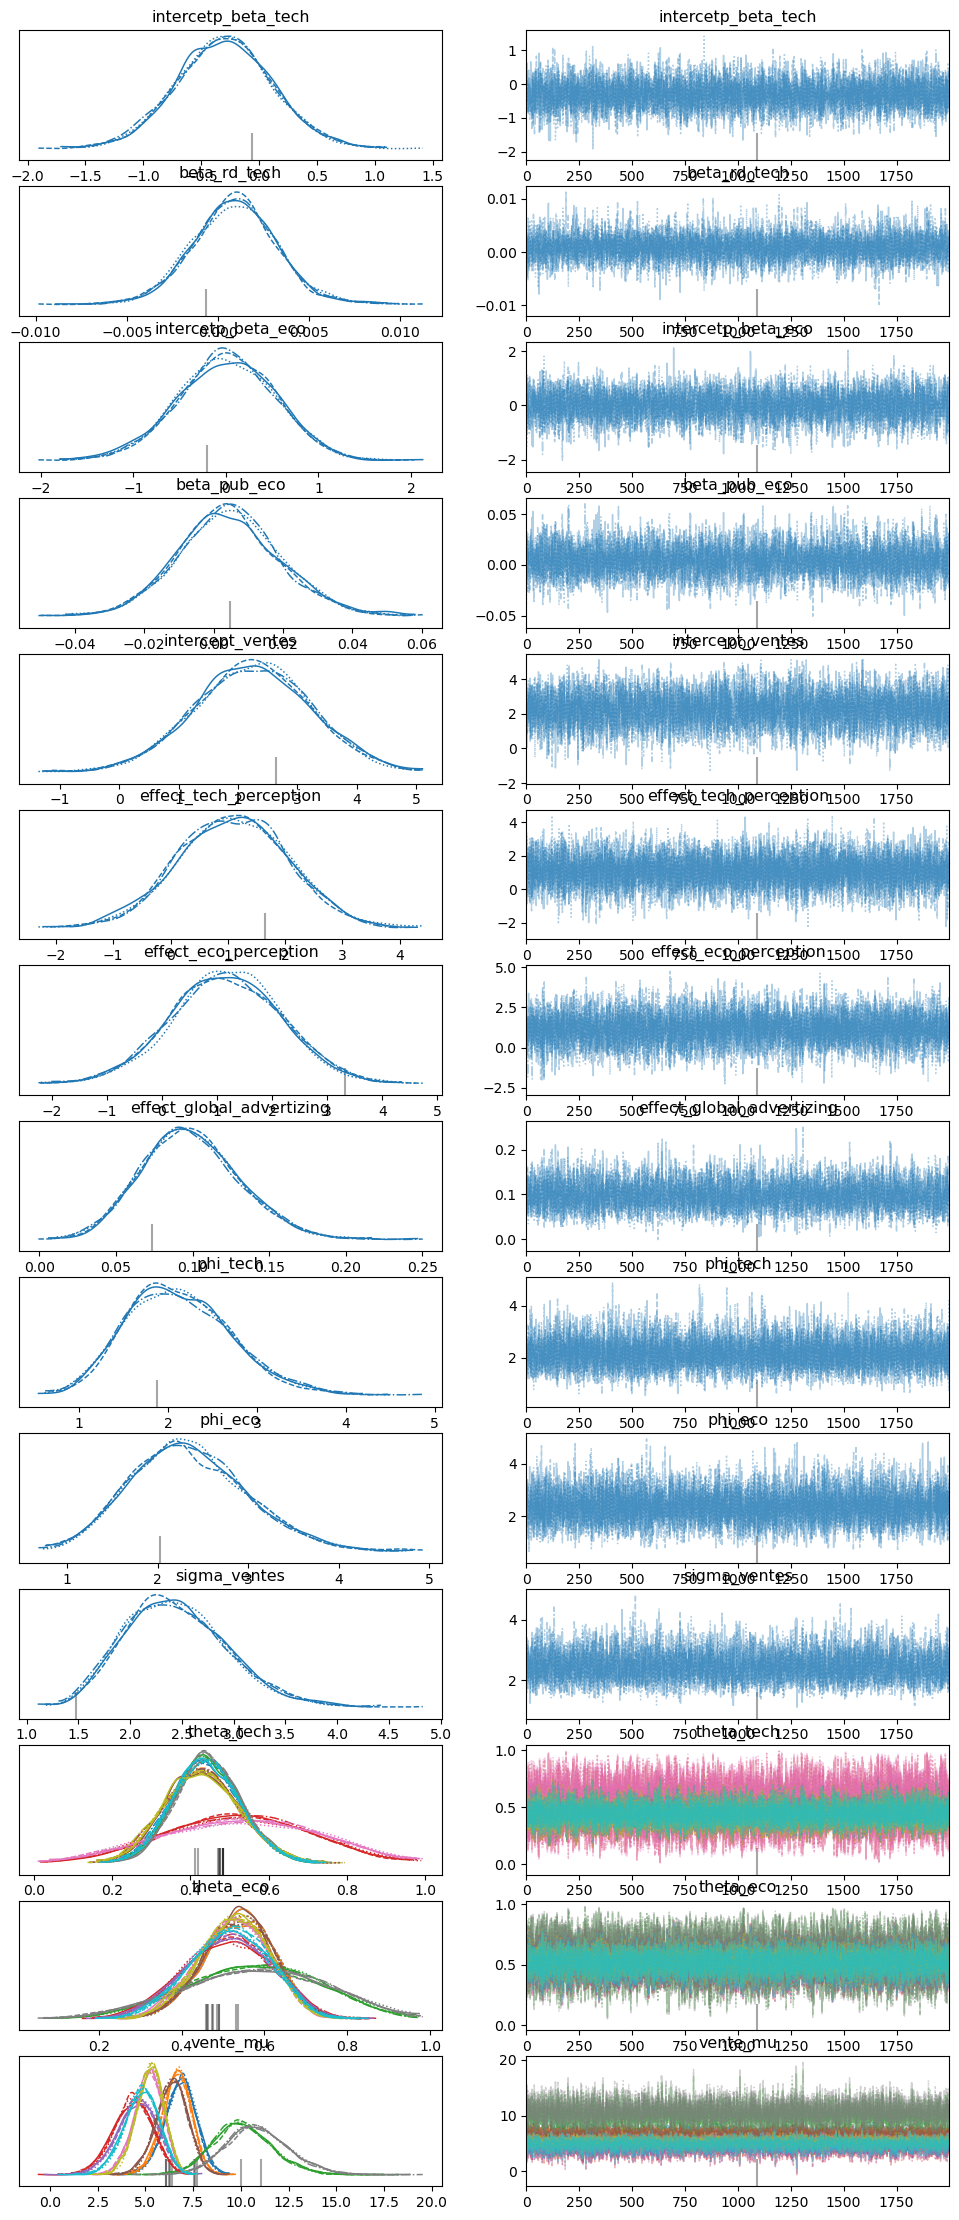

In [253]:
az.plot_trace(idata)
plt.show()


In [260]:
# Afficher les résumés des paramètres
#az.summary(idata)

### Select a subset of parameters to check more in detail - specifically the one in the structural equation - intermediary params are les interesting 

In [268]:

variables_a_afficher = [
    "intercetp_beta_tech",
    "beta_rd_tech",
    "intercetp_beta_eco",
    "beta_pub_eco",
    "intercept_ventes",
    "effect_tech_perception",
    "effect_eco_perception",
    "effect_global_advertizing"
]

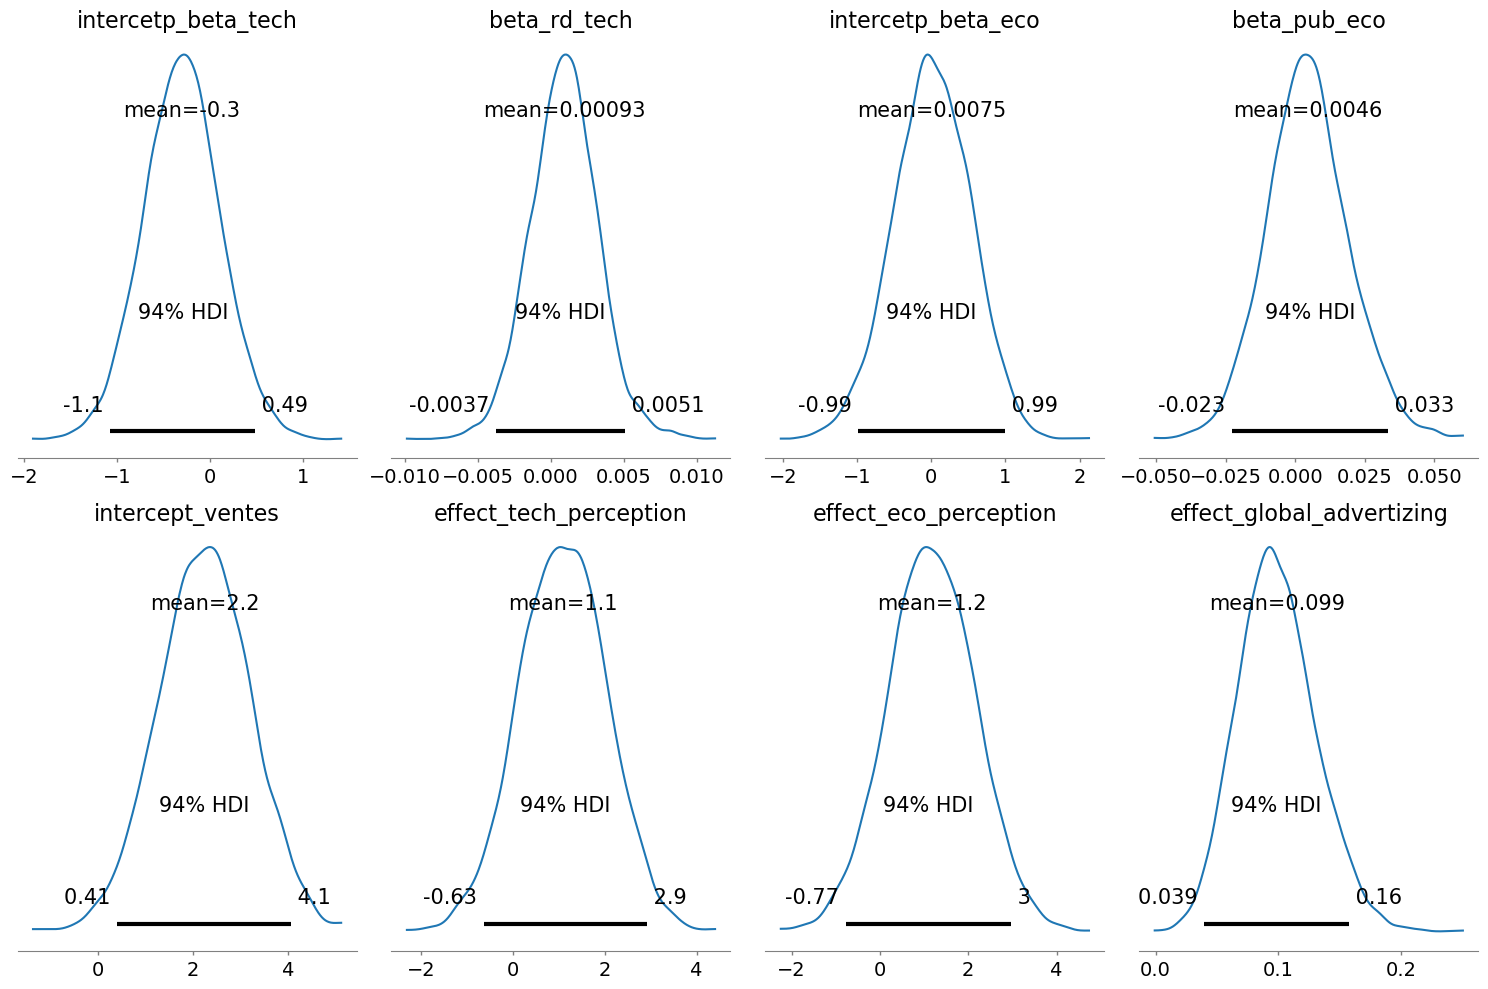

In [269]:
az.plot_posterior(
    idata,
    var_names=variables_a_afficher,
    figsize=(15, 10)  # Ajustez la taille en fonction du nombre de variables
)
plt.tight_layout();

## Sample data based on parameters posterior distribution to generate sales data

In [257]:
with model:
    # Générer des échantillons prédictifs postérieurs pour 'ventes'
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=["ventes"], random_seed=42)

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

### plot these Y data as a K Density Plot

In [258]:
ventes_pred = posterior_predictive.posterior_predictive["ventes"]
ventes_pred_array = ventes_pred.values
ventes_pred_flat = ventes_pred_array.flatten()

80000

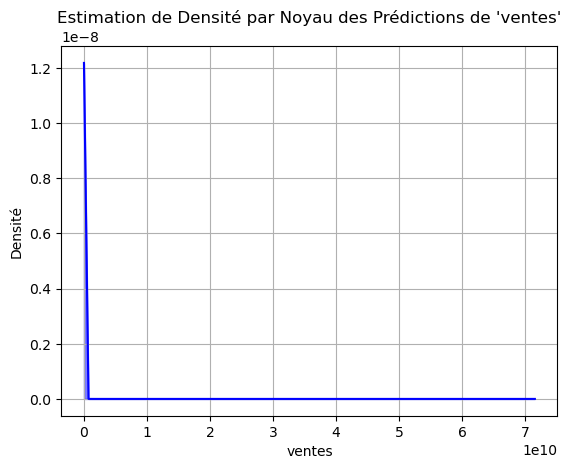

In [259]:
# Calculer le KDE
kde = gaussian_kde(ventes_pred_flat, bw_method='scott')  # bw_method peut être ajusté

# Créer une grille de points sur laquelle évaluer le KDE
x_grid = np.linspace(min(ventes_pred_flat), max(ventes_pred_flat), 100)

# Calculer les valeurs KDE sur la grille de points
kde_values = kde.evaluate(x_grid)

# Tracer le KDE avec matplotlib
plt.plot(x_grid, kde_values, color='blue')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='blue')
plt.title("Estimation de Densité par Noyau des Prédictions de 'ventes'")
plt.xlabel("ventes")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

## Generate new parameters predictions after imputing new data

In [299]:
# Nouvelles données pour les noeuds sans parents
researc_dev_downgrade = np.array([10, 12, 8, 9, 15, 18, 14, 89, 60, 13])  # Exemple de nouvelles données
ad_spend_downgrade = np.array([3, 5, 4, 6, 7, 2, 2, 8, 6, 7])         # Exemple de nouvelles données

# Mise à jour des valeurs pour les noeuds sans parents dans le modèle
with model:
    pm.set_data({"researc_dev": researc_dev_downgrade, "ad_spend": ad_spend_downgrade})
    # Générer des échantillons prédictifs pour les nouvelles données
    new_posterior_predictive_downgrade = pm.sample_posterior_predictive(idata, var_names=["tech_perception", "eco_perception","ventes"], random_seed=42)

# Accéder aux nouvelles prédictions pour 'ventes'
new_ventes_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["ventes"]
new_perception_eco_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["eco_perception"]
new_perception_tech_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["tech_perception"]

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [300]:
ventes_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["ventes"]
ventes_pred_downgrade_array = ventes_pred_downgrade.values
ventes_pred_downgrade_flat = ventes_pred_downgrade_array.flatten()

perception_eco_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["eco_perception"]
perception_eco_pred_downgrade_array = perception_eco_pred_downgrade.values
perception_eco_pred_downgrade_flat = perception_eco_pred_downgrade_array.flatten()

perception_tech_pred_downgrade = new_posterior_predictive_downgrade.posterior_predictive["tech_perception"]
perception_tech_pred_downgrade_array = perception_tech_pred_downgrade.values
perception_tech_pred_downgrade_flat = perception_tech_pred_downgrade_array.flatten()

In [301]:
# Nouvelles données pour les noeuds sans parents
researc_dev_cst = np.array([122, 122, 122, 122, 122, 122, 122, 122, 122, 122])  # Exemple de nouvelles données
ad_spend_cst = np.array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36])         # Exemple de nouvelles données

# Mise à jour des valeurs pour les noeuds sans parents dans le modèle
with model:
    pm.set_data({"researc_dev": researc_dev_cst, "ad_spend": ad_spend_cst})
    # Générer des échantillons prédictifs pour les nouvelles données
    new_posterior_predictive_cst = pm.sample_posterior_predictive(idata, var_names=["tech_perception", "eco_perception", "ventes"], random_seed=42)

# Accéder aux nouvelles prédictions pour 'ventes'
new_ventes_pred_cst = new_posterior_predictive_cst.posterior_predictive["ventes"]
new_perception_eco_pred_cst = new_posterior_predictive_cst.posterior_predictive["eco_perception"]
new_perception_tech_pred_cst = new_posterior_predictive_cst.posterior_predictive["tech_perception"]

Sampling: [eco_perception, tech_perception, ventes]


c:\Users\amaur\Anaconda3\envs\bayesian_network\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [302]:
ventes_pred_cst = new_posterior_predictive_cst.posterior_predictive["ventes"]
ventes_pred_cst_array = ventes_pred_cst.values
ventes_pred_cst_flat = ventes_pred_cst_array.flatten()

perception_eco_pred_cst = new_posterior_predictive_cst.posterior_predictive["eco_perception"]
perception_eco_pred_cst_array = perception_eco_pred_cst.values
perception_eco_pred_cst_flat = perception_eco_pred_cst_array.flatten()

perception_tech_pred_cst = new_posterior_predictive_cst.posterior_predictive["tech_perception"]
perception_tech_pred_cst_array = perception_tech_pred_cst.values
perception_tech_pred_cst_flat = perception_tech_pred_cst_array.flatten()

## Make the difference between the two predictions before and after adding data and check the difference for effect size

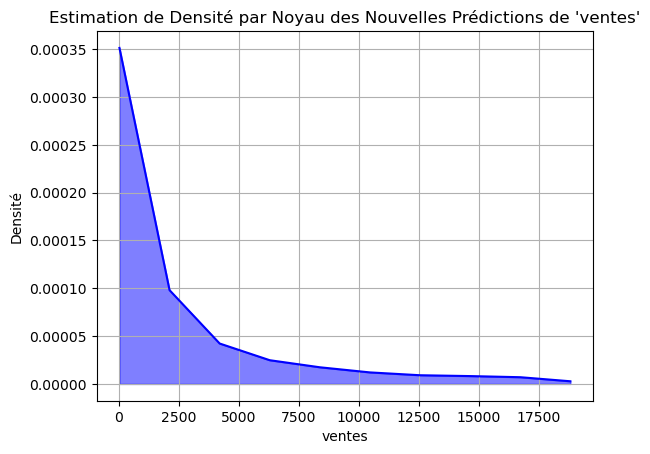

In [309]:
difference = ventes_pred_cst_flat - ventes_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='blue')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='blue')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'ventes'")
plt.xlabel("ventes")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

In [295]:
print(diff_filtered.min())
print(diff_filtered.mean())
print(diff_filtered.max())

37.416972273536
2682.887608739096
18806.26907593956


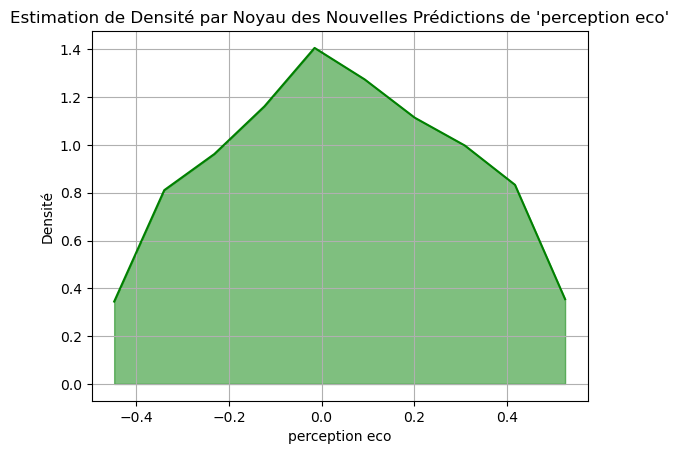

In [311]:
difference = perception_eco_pred_cst_flat - perception_eco_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='green')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='green')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'perception eco'")
plt.xlabel("perception eco")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

In [312]:
print(diff_filtered.min())
print(diff_filtered.mean())
print(diff_filtered.max())

-0.44722066035288394
0.039103796304151194
0.5245764578724474


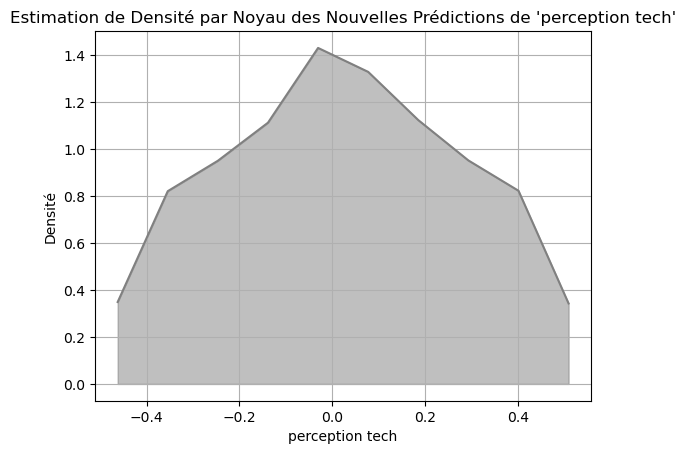

In [313]:
difference = perception_tech_pred_cst_flat - perception_tech_pred_downgrade_flat

lower_bound = np.percentile(difference, 12.5)
upper_bound = np.percentile(difference, 87.5)

diff_filtered = difference[(difference >= lower_bound) & (difference <= upper_bound)]
##########################################################
kde = gaussian_kde(diff_filtered, bw_method='scott')
x_grid = np.linspace(min(diff_filtered), max(diff_filtered), 10)
kde_values = kde.evaluate(x_grid)

plt.plot(x_grid, kde_values, color='grey')
plt.fill_between(x_grid, kde_values, alpha=0.5, color='grey')
plt.title("Estimation de Densité par Noyau des Nouvelles Prédictions de 'perception tech'")
plt.xlabel("perception tech")
plt.ylabel("Densité")
plt.grid(True)
plt.show()

In [314]:
print(diff_filtered.min())
print(diff_filtered.mean())
print(diff_filtered.max())

-0.46231007329368373
0.022721420815897973
0.5092828065921267
